In [19]:
import xml.etree.ElementTree as ET
import pandas as pd

## load and parse XML
tree = ET.parse('export.xml')
root = tree.getroot()

# Extract all records
records = []
for record in root.findall('Record'):
    records.append(record.attrib)

df = pd.DataFrame(records)


In [20]:
df.head()
df.info()
df.describe()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803664 entries, 0 to 1803663
Data columns (total 9 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   type           object
 1   sourceName     object
 2   sourceVersion  object
 3   unit           object
 4   creationDate   object
 5   startDate      object
 6   endDate        object
 7   value          object
 8   device         object
dtypes: object(9)
memory usage: 123.8+ MB


Index(['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate',
       'startDate', 'endDate', 'value', 'device'],
      dtype='object')

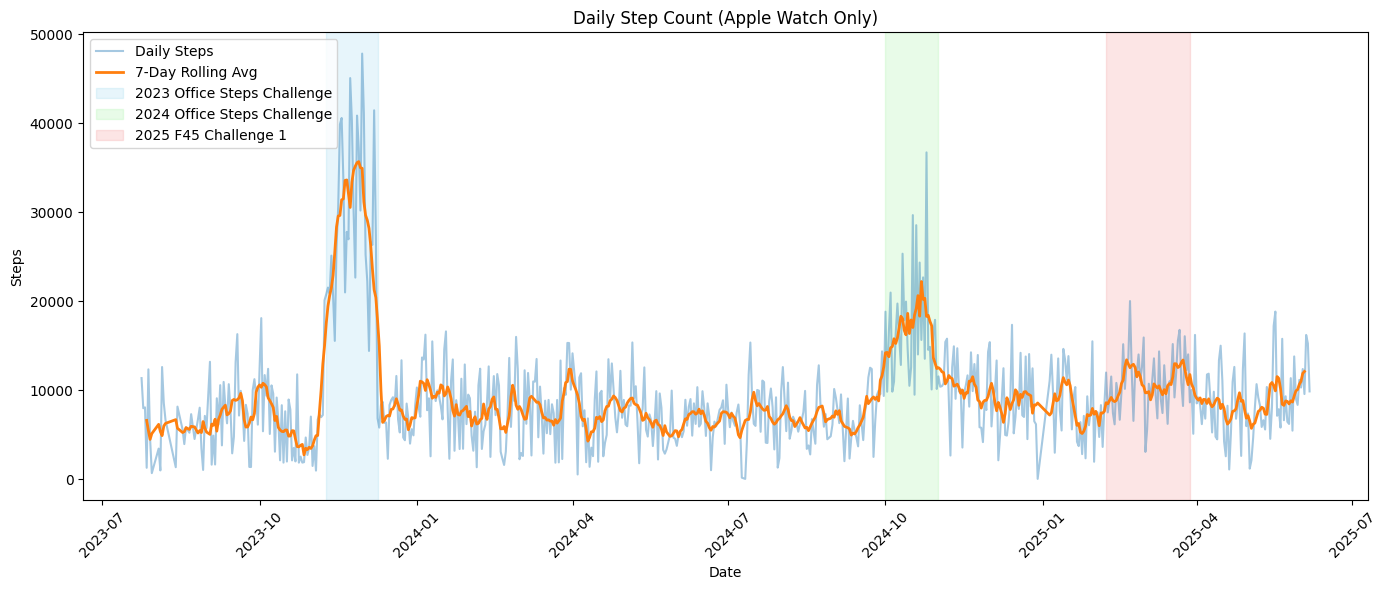

In [21]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# === Load XML ===
tree = ET.parse('export.xml')
root = tree.getroot()

# === Extract Step Count from Apple Watch ===
records = []
for record in root.findall('Record'):
    if (record.attrib['type'] == 'HKQuantityTypeIdentifierStepCount' and
        'Watch' in record.attrib.get('sourceName', '')):
        records.append({
            'value': float(record.attrib['value']),
            'startDate': pd.to_datetime(record.attrib['startDate']),
            'endDate': pd.to_datetime(record.attrib['endDate']),
            'source': record.attrib['sourceName']
        })

# === Create DataFrame ===
df_steps = pd.DataFrame(records)
df_steps['date'] = df_steps['startDate'].dt.date
daily_steps = df_steps.groupby('date')['value'].sum().reset_index()

# === Rolling Average ===
daily_steps['rolling_avg'] = daily_steps['value'].rolling(window=7, center=True).mean()

# === Plot ===
plt.figure(figsize=(14,6))
plt.plot(daily_steps['date'], daily_steps['value'], label='Daily Steps', alpha=0.4)
plt.plot(daily_steps['date'], daily_steps['rolling_avg'], label='7-Day Rolling Avg', linewidth=2)

# === Highlight Date Ranges ===
highlight_ranges = [
    ("2023-11-09", "2023-12-09", "2023 Office Steps Challenge", "skyblue"),
    ("2024-10-01", "2024-11-01", "2024 Office Steps Challenge", "lightgreen"),
    ("2025-02-07", "2025-03-28", "2025 F45 Challenge 1", "lightcoral")
]

for start_str, end_str, label, colour in highlight_ranges:
    start = pd.to_datetime(start_str)
    end = pd.to_datetime(end_str)
    plt.axvspan(start, end, color=colour, alpha=0.2, label=label)

# === Final Plot Settings ===
plt.title('Daily Step Count (Apple Watch Only)')
plt.xlabel('Date')
plt.ylabel('Steps')
plt.xticks(rotation=45)
#plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()



In [22]:
# List all unique sources for step count records
source_names = set()
for record in root.findall('Record'):
    if record.attrib['type'] == 'HKQuantityTypeIdentifierStepCount':
        source_names.add(record.attrib.get('sourceName'))

print(source_names)

## Needed to add condition that step count comes from watch only otherwise it is inflated by the phone records. 

{'Joshua’s iPhone', 'JB Watch'}
